# Sentiment Analysis

This notebook executes the NLP pipeline to:
1. **Compute Sentiment:** Classify reviews as Positive, Negative, or Neutral.
2. **Extract Themes:** Categorize feedback into buckets like "Transaction Issues" or "App Stability".
3. **Visualize Insights:** Generate charts for the Interim Report.

# Import Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('..'))

In [3]:
from src.config import PATHS
from src.sentiment_analyzer import SentimentAnalyzer
from src.theme_analyzer import ThemeClassifier

/home/bini/Documents/repos/Customer-Experience-Analytics/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set plot style for professional reports
sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', 100) # Show full review text

## Load Data

In [5]:
# Load cleaned data
try:
    df = pd.read_csv(f"../{PATHS['cleaned_data']}")
    print(f"Loaded {len(df)} reviews successfully.")
except FileNotFoundError:
    print("Error: Cleaned data not found. Please run Task 1 notebook first.")

Loaded 1265 reviews successfully.


## Sentiment Analysis

In [6]:
# Initialize Analyzer
sentiment_engine = SentimentAnalyzer()

# Run analysis
print("Calculating sentiment scores...")
df = sentiment_engine.analyze(df)

#Preview results
print(df[['review', 'sentiment_label', 'sentiment_score']].head())

Loading Sentiment Model (this may take a moment)...


Device set to use cpu


Calculating sentiment scores...
Running Sentiment Analysis...


100%|██████████| 1265/1265 [00:54<00:00, 23.30it/s]

                                                                                                review  \
0                                                                                  it's special for me   
1                                                                               Make it user friendly.   
2                                                                     maaliif daddafee install gaafata   
3                                                                                             good app   
4  This application is very important and advantage for transfer of money and finance in the coutry...   

  sentiment_label  sentiment_score  
0        POSITIVE         0.999820  
1        POSITIVE         0.992062  
2        NEGATIVE         0.987553  
3        POSITIVE         0.999849  
4        POSITIVE         0.998468  


## Sentiment Distribution

--- Sentiment Percentages ---


sentiment_label,NEGATIVE,POSITIVE
bank,,
Bank of Abyssinia,63.0,37.0
Commercial Bank of Ethiopia,44.2,55.8
Dashen Bank,36.1,63.9


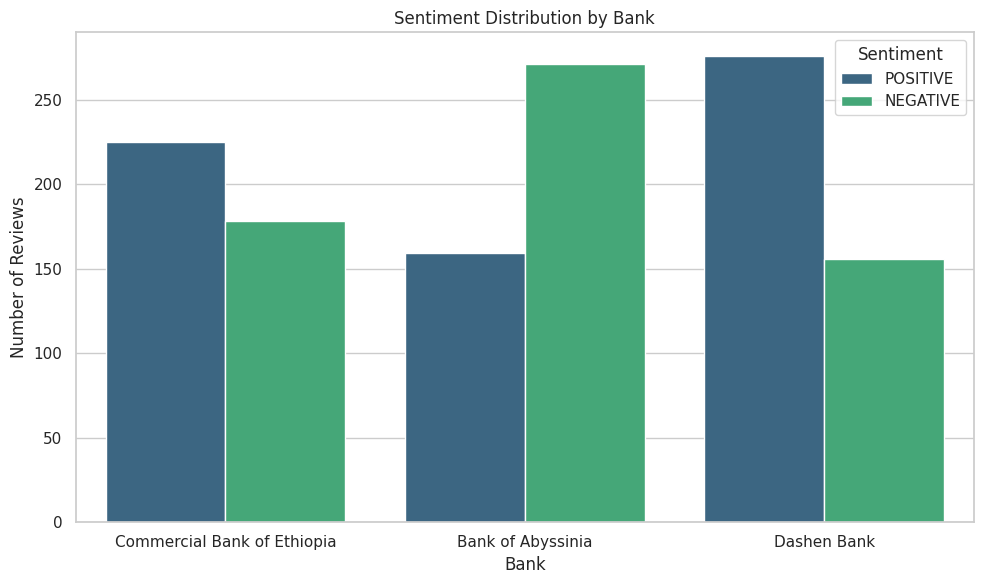

In [7]:
# Calculate percentages for the report text
sentiment_counts = df.groupby(['bank', 'sentiment_label']).size().unstack(fill_value=0)
sentiment_pcts = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

print("--- Sentiment Percentages ---")
display(sentiment_pcts.round(1))

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='bank', hue='sentiment_label', palette='viridis')
plt.title('Sentiment Distribution by Bank')
plt.ylabel('Number of Reviews')
plt.xlabel('Bank')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Thematic Analysis

In [8]:
# Initialize Classifier
theme_engine = ThemeClassifier()

# Apply Themes
df = theme_engine.apply_themes(df)

# Check the distribution of themes
print(df['theme'].value_counts())

Classifying Themes...
theme
General Feedback      917
Transaction Issues    124
App Stability          83
UI/UX                  79
Customer Support       36
Security & Access      26
Name: count, dtype: int64


## Theme Visualization

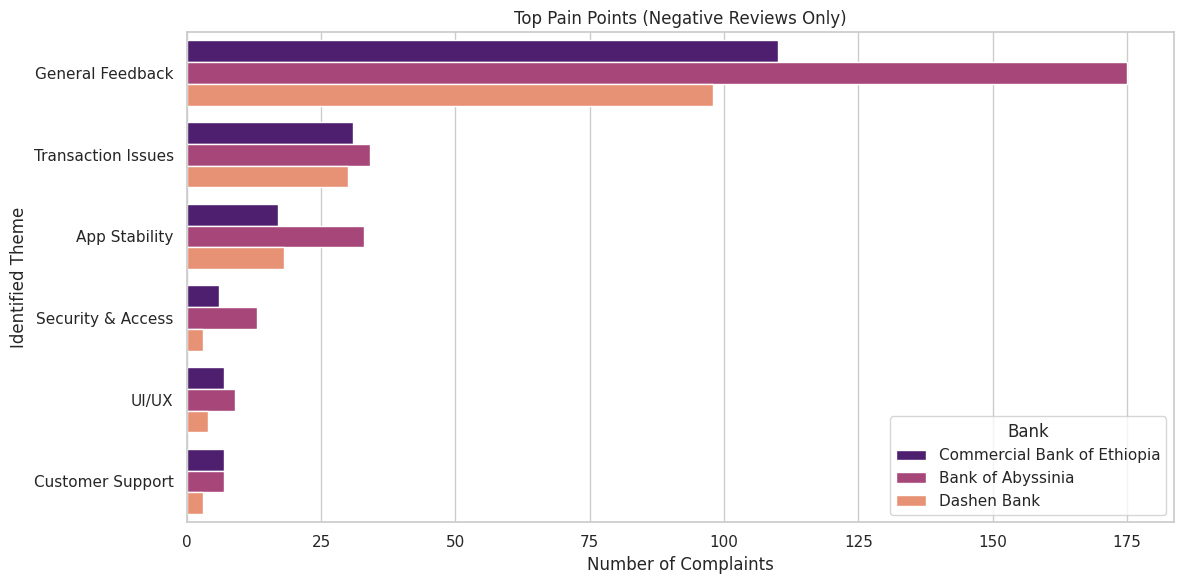

In [9]:
# Filter for Negative Sentiment only
negative_reviews = df[df['sentiment_label'] == 'NEGATIVE']

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=negative_reviews, 
    y='theme', 
    hue='bank', 
    palette='magma',
    order=negative_reviews['theme'].value_counts().index
)
plt.title('Top Pain Points (Negative Reviews Only)')
plt.xlabel('Number of Complaints')
plt.ylabel('Identified Theme')
plt.legend(title='Bank')
plt.tight_layout()
plt.show()

## Qualitative Insights

In [25]:
def get_top_examples(bank_name, theme):
    """Finds a RANDOM representative review for a bank's specific pain point."""
    subset = df[(df['bank'] == bank_name) & (df['theme'] == theme) & (df['sentiment_label'] == 'NEGATIVE')]
    
    if not subset.empty:
        return subset['review'].sample(1).iloc[0]
    return "No example found."

banks = df['bank'].unique()

print("--- Key Examples for Report (Randomized) ---")
for bank in banks:
    # Find the most common negative theme for this bank
    bank_neg = df[(df['bank'] == bank) & (df['sentiment_label'] == 'NEGATIVE')]
    
    if not bank_neg.empty:
        # Identify the most frequent pain point
        top_issue = bank_neg['theme'].mode()[0]
        
        # Get a random example review
        example = get_top_examples(bank, top_issue)
        
        print(f"\nBANK: {bank}")
        print(f"Top Pain Point: {top_issue}")
        print(f"Example Review: \"{example}\"")

--- Key Examples for Report (Randomized) ---

BANK: Commercial Bank of Ethiopia
Top Pain Point: General Feedback
Example Review: "the app say it is not compatible with ur phone can u fix it it is not updating."

BANK: Bank of Abyssinia
Top Pain Point: General Feedback
Example Review: "it just doesn't work...so frustrating"

BANK: Dashen Bank
Top Pain Point: General Feedback
Example Review: "convinent"


## Save Data

In [10]:
# Save to processed folder
df.to_csv(f"../{PATHS['final_data']}", index=False)
print(f"Analysis saved to ../{PATHS['final_data']}")

Analysis saved to ../data/processed/reviews_analyzed.csv
